In [1]:
import numpy as np
import sympy as sym
from sympy.solvers import solve

## **1. Implementing conjugate gradients method**

In [2]:
def conjugate_gradient(function, x_0, precision=0.01, show_iterations=False, use_restart=False):
    """
    Conjugate gradient descent method
        :param function: the given function
        :param x_0: starting point (an initial guess)
        :param precision: precision of the CGD method
        :param show_iterations: if set to True, prints each iteration of the algorithm
        :param use_restart: if set to True, activates restart procedure
        :return: approximated minimum of the function
    """
    variables = list(sym.ordered(function.free_symbols))
    dim = len(variables)
    gradient = sym.Matrix([function.diff(x) for x in variables])  # Symbolic gradient

    def substitute(func, expression):
        """
        Assisting function to shorten the operation of passing an expression to
        the input function and its gradient
            :param func: the given function
            :param expression: function's argument
            :return: function's value at a given point
        """
        result = sym.N(func.subs(list(zip(variables, expression))))
        return result

    def f(expression):
        """
        Shortens the operation of passing an expression to an input function
        """
        return substitute(function, expression)

    def grad(expression):
        """
        Shortens the operation of passing an expression to a gradient of an input function
        """
        return substitute(gradient, expression)

    def minimize_1d(func, variable):
        """
        1d minimization of the given function (performed by sympy.minimum())
            :param func: given function
            :param variable: variable which is to be minimized by
            :return: point of global minimum
        """
        f_min = sym.N(sym.minimum(func, variable))  # returns minimum of a function
        x_min = [sym.re(num) for num in solve(func - f_min, variable)]  # choosing only real parts if roots are complex
        x_min = sym.N(min(list(map(abs, list(map(float, x_min))))))  # converting precise value into float
        return x_min

    def norm(vector):
        """
        Calculates norm of the given vector
        :param vector:
        :return:
        """
        return np.linalg.norm(np.array(sym.N(vector)).astype(float))

    def print_iterations():
        if show_iterations is True:
            print(f"k={k} -----------------------------------")
            print('\n|Parameters|:')
            print(f"\t-grad(x_{k-1}) = {-grad(x_k[k-1])}\n")
            print(f"\ts_{k-1} = {s_k[k-1]}\n")
            print(f"\tbeta = {b}\n")
            print(f"\talpha = {alpha}\n")
            print('|GD Results|:')
            print(f"\t(symbolic) x_{k} = {x}\n")
            print(f"\tf_a = {f_a}\n")
            print(f"\tx_{k} = {x_k[k]}\n")
            print(f"A1: {abs(sym.N(f(x_k[k-1]) - f(x_k[k])))} ? {precision * (1 + np.abs(sym.N(f(x_k[k]))))}")
            print(f"A2: {norm(x_k[k-1] - x_k[k])} ? {np.sqrt(precision) * (1 + norm(x_k[k]))}")
            print(f"A3: {norm(grad(x_k[k]))} ? {precision**(1/3) * (1 + abs(sym.N(f(x_k[k]))))}\n")

    # 0-th iteration
    a = sym.Symbol('a')
    b = 0
    x_k = [sym.Matrix(x_0)]  # steps of minimization
    s_k = [sym.Matrix(-grad(x_0))]  # steps of anti-gradient

    total_iterations = 0
    
    k = 1
    while True:
        # Calculating x_k and f(x_k) for current (k) iteration
        x = x_k[k-1] + a * s_k[k-1]
        f_a = f(x)
        alpha = minimize_1d(f_a, a)
        x_k.append(sym.N(x.subs(a, alpha)))

        print_iterations()  # prints only if show_iterations=True

        # Calculating beta and s for the next (k+1) iteration
        numerator = norm(grad(x_k[k]))**2
        denominator = norm(grad(x_k[k-1]))**2

        if use_restart:
            b = numerator / denominator if k % dim != 0 else 0  # оновлення
        else:
            b = numerator / denominator

        s = -grad(x_k[k]) + b * s_k[k-1]
        s_k.append(s)

        # Stop criterion (with conditions A1-A3)
        A1 = abs(sym.N(f(x_k[k-1]) - f(x_k[k]))) < precision * (1 + abs(sym.N(f(x_k[k]))))
        A2 = norm(x_k[k-1] - x_k[k]) < np.sqrt(precision) * (1 + norm(x_k[k]))
        A3 = norm(grad(x_k[k])) <= precision**(1/3) * (1 + abs(sym.N(f(x_k[k]))))
        if A1 and A2 and A3:
            total_iterations = k
            break

        k += 1

    x_k = np.array(x_k).astype(float)  # converting back to list

    if show_iterations is True:
        print("\n---------------------------------------")
        print(f"Iterations: {k}")

    return x_k, total_iterations

## **2. CGD test on different function**

In [3]:
def cgd_test(precision=0.001):
    # -------------------- Test functions --------------------
    
    # Test 1. Rosenbrock function with n=2
    x1, x2 = sym.symbols('x1 x2')
    f_rosen = 100*(x2 - x1**2)**2 + (1-x1)**2
    x_0 = [-1.2, 1]
    
    history_rosen_default = conjugate_gradient(f_rosen, x_0, precision, show_iterations=False, use_restart=False)
    history_rosen_restart = conjugate_gradient(f_rosen, x_0, precision, show_iterations=False, use_restart=True)

    print("------------ Test 1 ------------")
    print(f"Found point of minimum x_min (without restart): \n{history_rosen_default[0][-1]}")
    print(f"Found point of minimum x_min (with restart): \n{history_rosen_restart[0][-1]}")
    print(f"Total iterations (without restart): {history_rosen_default[1]}")
    print(f"Total iterations (with restart): {history_rosen_restart[1]}")
    print(f"True point of minimum: (1, 1)\n")
    
    
    # # Test 2. Powell`s function
    # x1, x2, x3, x4 = sym.symbols('x1 x2 x3 x4')
    # f_powell = (x1+10*x2)**2 + 5*(x3-x4)**2 + (x2-2*x3)**4 + 10*(x1-x4)**4
    # x_0 = [3, -1, 0, 1]
    #
    # history_powell_default = conjugate_gradient(f_powell, x_0, precision, show_iterations=False, use_restart=False)
    # history_powell_restart = conjugate_gradient(f_powell, x_0, precision, show_iterations=False, use_restart=True)
    #
    # print("------------ Test 2 ------------")
    # print(f"Found point of minimum x_min (without restart): \n{history_powell_default[0][-1]}")
    # print(f"Found point of minimum x_min (with restart): \n{history_powell_restart[0][-1]}")
    # print(f"Total iterations (without restart): {history_powell_default[1]}")
    # print(f"Total iterations (with restart): {history_powell_restart[1]}")
    # print(f"True point of minimum: (0, 0, 0, 0)\n")
    #
    #
    # # Test 3
    # x1, x2 = sym.symbols('x1 x2')
    # f_test3 = 100*(x2-x1**3)**2 + (1-x1)**2
    # x_0 = [-1.2, 1]
    #
    # history_test3_default = conjugate_gradient(f_test3, x_0, precision, show_iterations=False, use_restart=False)
    # history_test3_restart = conjugate_gradient(f_test3, x_0, precision, show_iterations=False, use_restart=True)
    #
    # print("------------ Test 3 ------------")
    # print(f"Found point of minimum x_min (without restart): \n{history_test3_default[0][-1]}")
    # print(f"Found point of minimum x_min (with restart): \n{history_test3_restart[0][-1]}")
    # print(f"Total iterations (without restart): {history_test3_default[1]}")
    # print(f"Total iterations (with restart): {history_test3_restart[1]}")
    # print(f"True point of minimum: (1, 1)\n")
    #
    #
    # # Test 4
    # x1, x2, x3 = sym.symbols('x1 x2 x3')
    # f_test4 = 100*(x3 - ((x1+x2)/2)**2)**2 + (1-x1)**2 + (1-x2)**2
    # x_0 = [-1.2, 2, 0]
    #
    # history_test4_default = conjugate_gradient(f_test4, x_0, precision, show_iterations=False, use_restart=False)
    # history_test4_restart = conjugate_gradient(f_test4, x_0, precision, show_iterations=False, use_restart=True)
    #
    # print("------------ Test 4 ------------")
    # print(f"Found point of minimum x_min (without restart): \n{history_test4_default[0][-1]}")
    # print(f"Found point of minimum x_min (with restart): \n{history_test4_restart[0][-1]}")
    # print(f"Total iterations (without restart): {history_test4_default[1]}")
    # print(f"Total iterations (with restart): {history_test4_restart[1]}")
    # print(f"True point of minimum: (1, 1, 1)\n")

    # return ((f_rosen, history_rosen_default, history_rosen_restart),
    #         (f_powell, history_powell_default, history_powell_restart),
    #         (f_test3, history_test3_default, history_test3_restart),
    #         (f_test4, history_test4_default, history_test4_restart))

    return f_rosen, history_rosen_default, history_rosen_restart

In [4]:
tau = 0.001 # 0.01
all_histories_1 = cgd_test(tau)

------------ Test 1 ------------
Found point of minimum x_min (without restart): 
[[1.02261752]
 [1.04567706]]
Found point of minimum x_min (with restart): 
[[0.96839693]
 [0.93766621]]
Total iterations (without restart): 70
Total iterations (with restart): 43
True point of minimum: (1, 1)



In [116]:
list(all_histories_1[0][2][0][-1].squeeze(axis=1))

[0.7920803402573223, 0.626501298974985]

In [104]:
all_histories_1[1][1][0][-1]

array([[ 0.20031569],
       [-0.01915081],
       [ 0.0982216 ],
       [ 0.10936673]])

In [122]:
# Rosenbrock
func = all_histories_1[0][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_1[0][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_1[0][2][0][-1].squeeze(axis=1)))}")
print()


# Powell
func = all_histories_1[1][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_1[1][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_1[1][2][0][-1].squeeze(axis=1)))}")
print()


# Test 3
func = all_histories_1[2][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_1[2][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_1[2][2][0][-1].squeeze(axis=1)))}")
print()

# Test 4
func = all_histories_1[3][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_1[3][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_1[3][2][0][-1].squeeze(axis=1)))}")
print()

(1 - x1)**2 + 100*(-x1**2 + x2)**2
Default: f_min = 0.0412031092233022
Restart: f_min = 0.0433097889352198

(x1 + 10*x2)**2 + 10*(x1 - x4)**4 + (x2 - 2*x3)**4 + 5*(x3 - x4)**2
Default: f_min = 0.0035433179429347345
Restart: f_min = 0.009650701980011334

(1 - x1)**2 + 100*(-x1**3 + x2)**2
Default: f_min = 0.004907361929137643
Restart: f_min = 0.052393310894372

(1 - x1)**2 + (1 - x2)**2 + 100*(x3 - (x1/2 + x2/2)**2)**2
Default: f_min = 0.0012800639673604837
Restart: f_min = 0.014335941214732613



In [71]:
tau = 0.001
all_histories_2 = cgd_test(tau)

------------ Test 1 ------------
Found point of minimum x_min (without restart): 
[[1.02261899]
 [1.04568004]]
Found point of minimum x_min (with restart): 
[[0.96840962]
 [0.93769083]]
Total iterations (without restart): 70
Total iterations (with restart): 43
True point of minimum: (1, 1)

------------ Test 2 ------------
Found point of minimum x_min (without restart): 
[[ 0.14313228]
 [-0.01470762]
 [ 0.06956347]
 [ 0.07116442]]
Found point of minimum x_min (with restart): 
[[ 0.15627731]
 [-0.01557674]
 [ 0.05985749]
 [ 0.06346754]]
Total iterations (without restart): 31
Total iterations (with restart): 22
True point of minimum: (0, 0, 0, 0)

------------ Test 3 ------------
Found point of minimum x_min (without restart): 
[[0.93018047]
 [0.80448852]]
Found point of minimum x_min (with restart): 
[[0.92399631]
 [0.78862581]]
Total iterations (without restart): 39
Total iterations (with restart): 33
True point of minimum: (1, 1)

------------ Test 4 ------------
Found point of minimu

In [123]:
# Rosenbrock
func = all_histories_1[0][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_2[0][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_2[0][2][0][-1].squeeze(axis=1)))}")
print()


# Powell
func = all_histories_1[1][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_2[1][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_2[1][2][0][-1].squeeze(axis=1)))}")
print()


# Test 3
func = all_histories_1[2][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_2[2][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_2[2][2][0][-1].squeeze(axis=1)))}")
print()

# Test 4
func = all_histories_1[3][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_2[3][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_2[3][2][0][-1].squeeze(axis=1)))}")
print()

(1 - x1)**2 + 100*(-x1**2 + x2)**2
Default: f_min = 0.0005121025104702353
Restart: f_min = 0.0009995487840048646

(x1 + 10*x2)**2 + 10*(x1 - x4)**4 + (x2 - 2*x3)**4 + 5*(x3 - x4)**2
Default: f_min = 0.0008566647068500866
Restart: f_min = 0.0011424036349122868

(1 - x1)**2 + 100*(-x1**3 + x2)**2
Default: f_min = 0.004886112917312471
Restart: f_min = 0.005783000198651126

(1 - x1)**2 + (1 - x2)**2 + 100*(x3 - (x1/2 + x2/2)**2)**2
Default: f_min = 0.00024781835300165933
Restart: f_min = 0.0029213420651687345



In [85]:
tau = 0.0001
all_histories_3 = cgd_test(tau)

------------ Test 1 ------------
Found point of minimum x_min (without restart): 
[[1.01070729]
 [1.02166249]]
Found point of minimum x_min (with restart): 
[[0.99055232]
 [0.98115667]]
Total iterations (without restart): 79
Total iterations (with restart): 45
True point of minimum: (1, 1)

------------ Test 2 ------------
Found point of minimum x_min (without restart): 
[[ 0.11008542]
 [-0.01079612]
 [ 0.05381651]
 [ 0.05374424]]
Found point of minimum x_min (with restart): 
[[ 0.11840805]
 [-0.01173384]
 [ 0.06861363]
 [ 0.06883957]]
Total iterations (without restart): 40
Total iterations (with restart): 24
True point of minimum: (0, 0, 0, 0)

------------ Test 3 ------------
Found point of minimum x_min (without restart): 
[[0.97700063]
 [0.93243824]]
Found point of minimum x_min (with restart): 
[[0.98789028]
 [0.96407219]]
Total iterations (without restart): 53
Total iterations (with restart): 39
True point of minimum: (1, 1)

------------ Test 4 ------------
Found point of minimu

In [124]:
# Rosenbrock
func = all_histories_3[0][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_3[0][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_3[0][2][0][-1].squeeze(axis=1)))}")
print()


# Powell
func = all_histories_1[1][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_3[1][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_3[1][2][0][-1].squeeze(axis=1)))}")
print()


# Test 3
func = all_histories_1[2][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_3[2][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_3[2][2][0][-1].squeeze(axis=1)))}")
print()

# Test 4
func = all_histories_1[3][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_3[3][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_3[3][2][0][-1].squeeze(axis=1)))}")
print()

(1 - x1)**2 + 100*(-x1**2 + x2)**2
Default: f_min = 0.00011642211413626271
Restart: f_min = 8.939728262675815e-05

(x1 + 10*x2)**2 + 10*(x1 - x4)**4 + (x2 - 2*x3)**4 + 5*(x3 - x4)**2
Default: f_min = 0.0003020155530035862
Restart: f_min = 0.0005541394288337255

(1 - x1)**2 + 100*(-x1**3 + x2)**2
Default: f_min = 0.0005308864563172245
Restart: f_min = 0.00014678077924545478

(1 - x1)**2 + (1 - x2)**2 + 100*(x3 - (x1/2 + x2/2)**2)**2
Default: f_min = 8.645540889972255e-05
Restart: f_min = 0.000352215157770629



In [86]:
tau = 0.00001
all_histories_4 = cgd_test(tau)

------------ Test 1 ------------
Found point of minimum x_min (without restart): 
[[1.00502869]
 [1.01013328]]
Found point of minimum x_min (with restart): 
[[0.99553585]
 [0.99107728]]
Total iterations (without restart): 89
Total iterations (with restart): 47
True point of minimum: (1, 1)

------------ Test 2 ------------
Found point of minimum x_min (without restart): 
[[ 0.08319683]
 [-0.00839427]
 [ 0.0415263 ]
 [ 0.0416799 ]]
Found point of minimum x_min (with restart): 
[[ 0.10014003]
 [-0.00995227]
 [ 0.03759869]
 [ 0.03742836]]
Total iterations (without restart): 53
Total iterations (with restart): 28
True point of minimum: (0, 0, 0, 0)

------------ Test 3 ------------
Found point of minimum x_min (without restart): 
[[0.98897297]
 [0.96721774]]
Found point of minimum x_min (with restart): 
[[0.99628853]
 [0.98889573]]
Total iterations (without restart): 63
Total iterations (with restart): 41
True point of minimum: (1, 1)

------------ Test 4 ------------
Found point of minimu

In [125]:
# Rosenbrock
func = all_histories_1[0][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_4[0][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_4[0][2][0][-1].squeeze(axis=1)))}")
print()


# Powell
func = all_histories_1[1][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_4[1][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_4[1][2][0][-1].squeeze(axis=1)))}")
print()


# Test 3
func = all_histories_1[2][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_4[2][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_4[2][2][0][-1].squeeze(axis=1)))}")
print()

# Test 4
func = all_histories_1[3][0]
variables = list(sym.ordered(func.free_symbols))
function = sym.lambdify(variables, func)

print(func)
print(f"Default: f_min = {function(*list(all_histories_4[3][1][0][-1].squeeze(axis=1)))}")
print(f"Restart: f_min = {function(*list(all_histories_4[3][2][0][-1].squeeze(axis=1)))}")
print()

(1 - x1)**2 + 100*(-x1**2 + x2)**2
Default: f_min = 2.5543940963429617e-05
Restart: f_min = 1.994922347867595e-05

(x1 + 10*x2)**2 + 10*(x1 - x4)**4 + (x2 - 2*x3)**4 + 5*(x3 - x4)**2
Default: f_min = 0.00010031605176482846
Restart: f_min = 0.00020776087191711411

(1 - x1)**2 + 100*(-x1**3 + x2)**2
Default: f_min = 0.0001220128350732157
Restart: f_min = 1.3787401532241124e-05

(1 - x1)**2 + (1 - x2)**2 + 100*(x3 - (x1/2 + x2/2)**2)**2
Default: f_min = 3.63269354847071e-05
Restart: f_min = 0.000241948526972488



## **3. Plotting functions of $dim \leqslant 3$**

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [50]:
def plot_3d(func, history, xlim_=(-2, 2), ylim_=(-2, 2)):
    # Converting sympy function to lambda expression
    variables = list(sym.ordered(func.free_symbols))
    function = sym.lambdify(variables, func)
    
    # Generate a grid of points
    x_vals = np.linspace(*xlim_, 1000)
    y_vals = np.linspace(*ylim_, 1000)
    X, Y = np.meshgrid(x_vals, y_vals)
    F = function(X, Y)
    
    # Create a custom colormap
    hot_colormap = plt.get_cmap('hot')
    hot_colors = hot_colormap(np.linspace(0, 1, 256))
    
    # Set values below a certain threshold to blue
    threshold = 1e-10
    below_threshold_color = np.array([0, 0, 1, 1])  # RGBA for blue
    
    # Find the index where the colormap should start changing
    threshold_index = np.searchsorted(np.linspace(0, np.max(F), 256), threshold)
    
    # Modify the colormap
    new_colors = hot_colors.copy()
    new_colors[:threshold_index] = below_threshold_color
    
    # Create a new colormap with the modified colors
    custom_colormap = ListedColormap(new_colors)
    
    # 3D plot of a function
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, F, cmap=custom_colormap, edgecolor='none', zorder=4)
    
    # Add a color bar which maps values to colors
    fig.colorbar(surface)
    
    # Add labels and title
    ax.set_title('Rosenbrock Function')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f \ (x_1, x_2)$', rotation=90)
    
    points = np.array(history).squeeze(axis=2)
    
    # Calculate the corresponding f(x1, x2) values
    f_values = function(points[:, 0], points[:, 1])
    
    # Connect the points with straight lines
    ax.plot(points[:, 0], points[:, 1], f_values, color='#bebebe', linestyle='--',
            linewidth=1.2, markersize=3, marker='o', label='CGD path', zorder=5)
    
    # Add a legend
    ax.legend()
    
    plt.show()

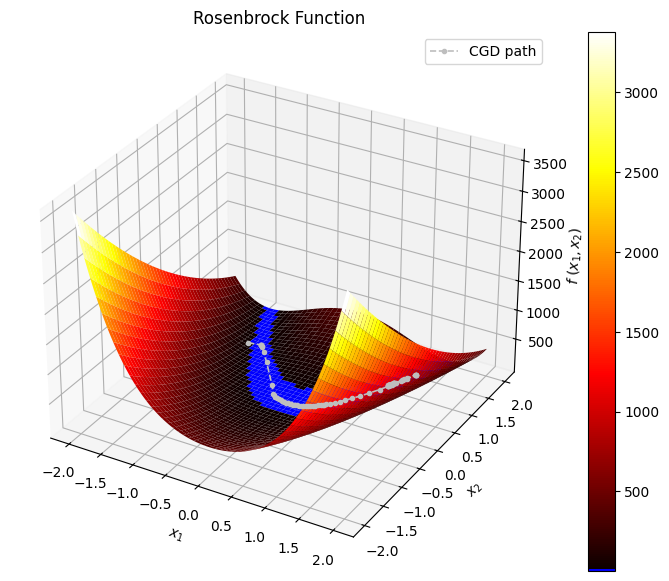

In [51]:
plot_3d(all_histories[0][0], history=all_histories[0][1][0], xlim_=(-2, 2), ylim_=(-2, 2))

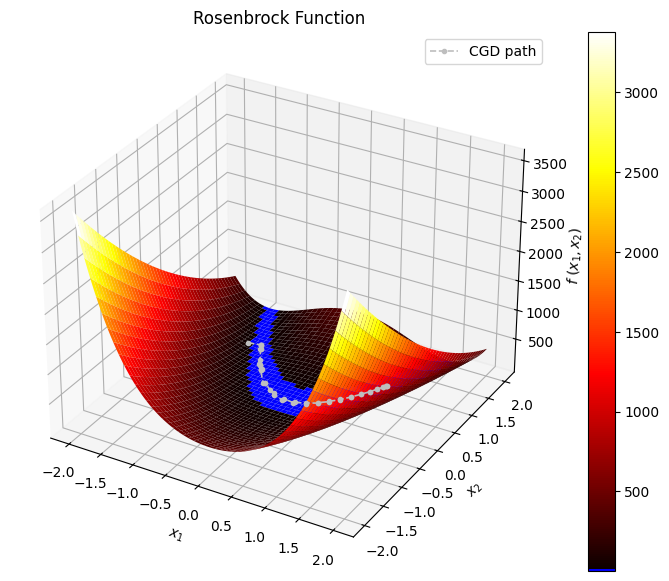

In [62]:
plot_3d(all_histories[0][0], history=all_histories[0][2][0], xlim_=(-2, 2), ylim_=(-2, 2))

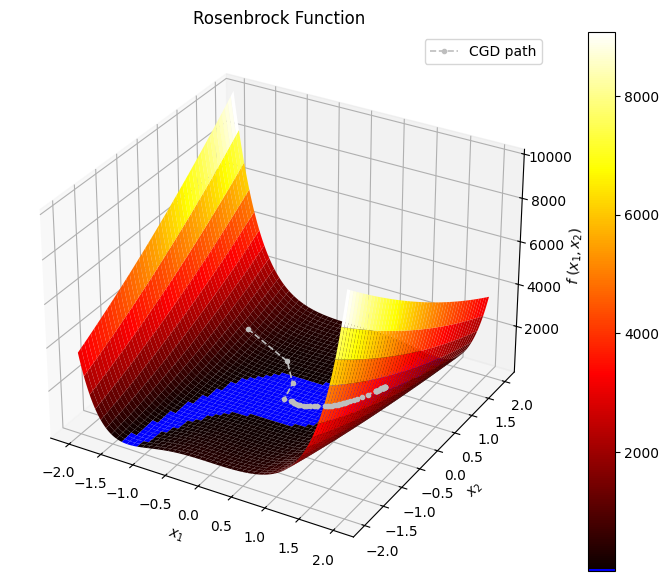

In [57]:
plot_3d(all_histories[2][0], history=all_histories[2][1][0], xlim_=(-2, 2), ylim_=(-2, 2))

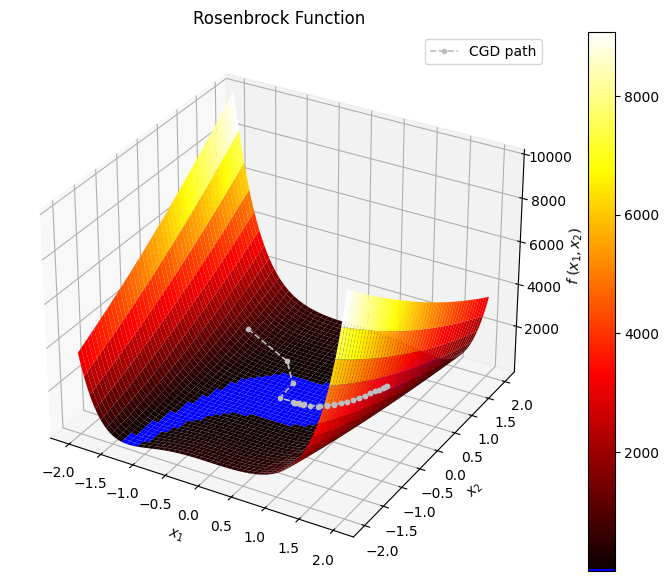

In [63]:
plot_3d(all_histories[2][0], history=all_histories[2][2][0], xlim_=(-2, 2), ylim_=(-2, 2))

In [70]:
all_histories[2][2][0]

array([[[-1.2       ],
        [ 1.        ]],

       [[-0.47053942],
        [ 0.83145802]],

       [[-0.14040745],
        [ 0.40291914]],

       [[-0.10506635],
        [-0.00212125]],

       [[ 0.09408038],
        [ 0.00981766]],

       [[ 0.11194193],
        [-0.00744292]],

       [[ 0.1371893 ],
        [-0.00638133]],

       [[ 0.15074192],
        [ 0.00857519]],

       [[ 0.18932897],
        [ 0.01190883]],

       [[ 0.21175511],
        [-0.00135964]],

       [[ 0.24931352],
        [ 0.00389501]],

       [[ 0.2566339 ],
        [ 0.0197888 ]],

       [[ 0.34285663],
        [ 0.03858298]],

       [[ 0.44112435],
        [ 0.06691989]],

       [[ 0.46060506],
        [ 0.07985554]],

       [[ 0.45608505],
        [ 0.09336652]],

       [[ 0.5371729 ],
        [ 0.14529337]],

       [[ 0.53473911],
        [ 0.15154935]],

       [[ 0.60922348],
        [ 0.21633953]],

       [[ 0.60595424],
        [ 0.2209201 ]],

       [[ 0.66972718],
        [ 0.29232

In [97]:
all_histories_4[2][1][1]

63

In [99]:
all_histories_4[2][1][0]

array([[[-1.2       ],
        [ 1.        ]],

       [[-0.47053942],
        [ 0.83145802]],

       [[-0.14040745],
        [ 0.40291914]],

       [[-0.04005145],
        [-0.00263484]],

       [[ 0.06120825],
        [ 0.01866906]],

       [[ 0.06402749],
        [ 0.01808826]],

       [[ 0.08858049],
        [ 0.00609734]],

       [[ 0.12563662],
        [-0.01332017]],

       [[ 0.15754588],
        [-0.02151646]],

       [[ 0.19208967],
        [-0.02504266]],

       [[ 0.20860562],
        [-0.02474981]],

       [[ 0.22536276],
        [-0.02258116]],

       [[ 0.26799384],
        [-0.01238409]],

       [[ 0.31040037],
        [ 0.00281464]],

       [[ 0.352248  ],
        [ 0.02375544]],

       [[ 0.38821578],
        [ 0.04882426]],

       [[ 0.40381668],
        [ 0.06460129]],

       [[ 0.42929703],
        [ 0.08265851]],

       [[ 0.52156742],
        [ 0.1274258 ]],

       [[ 0.53795956],
        [ 0.13749412]],

       [[ 0.55635916],
        [ 0.15077

In [43]:
variables

NameError: name 'variables' is not defined